## Scalings of inputs and outputs, and if local scaling makes sense.

In [2]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

import xgcm

import sys
sys.path.append('../modules/')
import helper_func as hf

# Import seaborn
import seaborn as sns

In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
import datasets

In [5]:
MITgcm_bucket ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

MITgcm_data = datasets.MITgcm_all_transformer('-', L='all')
MITgcm_data.read_datatree(MITgcm_bucket)

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_50km_3D
Centered
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_200km_3D
Centered
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_400km_3D
Centered


In [6]:
MITgcm_data.datatree = MITgcm_data.datatree.isel(time=slice(-50, -1))
MITgcm_data.datatree.load();

In [7]:
MOM6_DG_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_'
file_names= ''
L = 'all'
MOM6_DG_data = datasets.MOM6_all_transformer('-', 'all')
MOM6_DG_data.read_datatree(MOM6_DG_bucket, file_names, H_mask=500, large_filt=4)

Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_50km.zarr
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_100km.zarr
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_200km.zarr
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_400km.zarr
Subsampling


In [8]:
MOM6_P2L_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/'
L = 'all'
MOM6_P2L_data = datasets.MOM6_all_transformer('-', 'all')
MOM6_P2L_data.read_datatree(MOM6_P2L_bucket)

Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_100km.zarr
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_200km.zarr
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr
Subsampling


In [9]:
MOM6_DG_data.datatree = MOM6_DG_data.datatree.isel(Time=slice(-50, -1))
MOM6_DG_data.datatree.load();
MOM6_P2L_data.datatree = MOM6_P2L_data.datatree.isel(Time=slice(-50, -1))
MOM6_P2L_data.datatree.load();

In [10]:
def calc_mags(dataTREE):
    
    for L in ['50', '100', '200', '400']:
        ds = dataTREE.datatree[L]#.isel(time=slice(400, -1))
    
        magGradU = (ds.U_x**2 + ds.U_y**2 + ds.V_x**2 + ds.V_y**2)**0.5
        magS = (ds.Sx**2 + ds.Sy**2)**0.5

        magSfn = (ds.Sfnx**2 + ds.Sfny**2)**0.5

        PEdiss = (ds.Sfnx*ds.Sx + ds.Sfny*ds.Sy)
        Kdiss = (ds.Sfnx*ds.Sx + ds.Sfny*ds.Sy) / magS**2
        PEdiss_norm = (ds.Sfnx*ds.Sx + ds.Sfny*ds.Sy) / magS / magSfn
    
        dataTREE.datatree[L]['gradU'] = magGradU
        dataTREE.datatree[L]['magS']  = magS
        dataTREE.datatree[L]['magSfn']  = magSfn

        dataTREE.datatree[L]['PEdiss']  = PEdiss
        dataTREE.datatree[L]['Kappa']  = Kdiss
        dataTREE.datatree[L]['PEdiss_norm']  = PEdiss_norm

    return dataTREE

In [11]:
MOM6_DG_data = calc_mags(MOM6_DG_data)
MOM6_P2L_data = calc_mags(MOM6_P2L_data)
MITgcm_data = calc_mags(MITgcm_data)

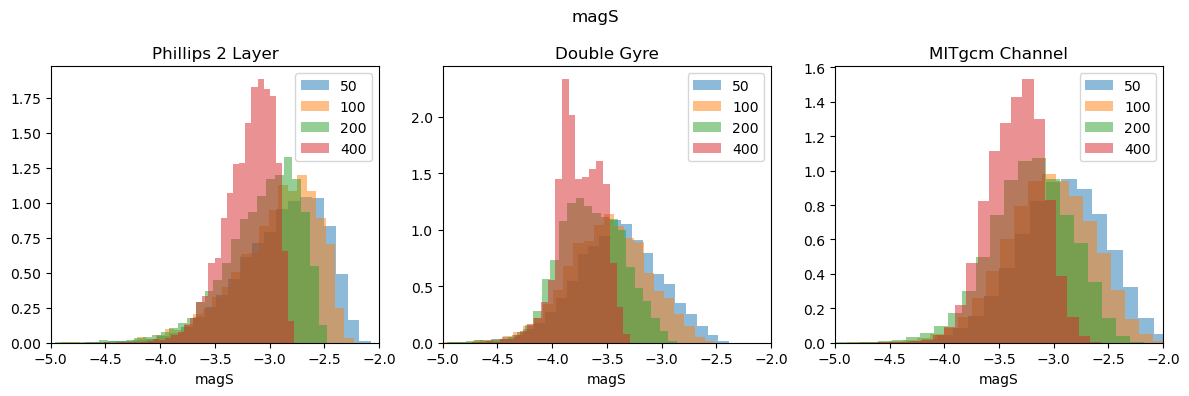

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_P2L_data.datatree[L]['magS']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([-5, -2])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_DG_data.datatree[L]['magS']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([-5, -2])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    np.log10(MITgcm_data.datatree[L]['magS']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([-5, -2])

plt.suptitle('magS')
plt.tight_layout()



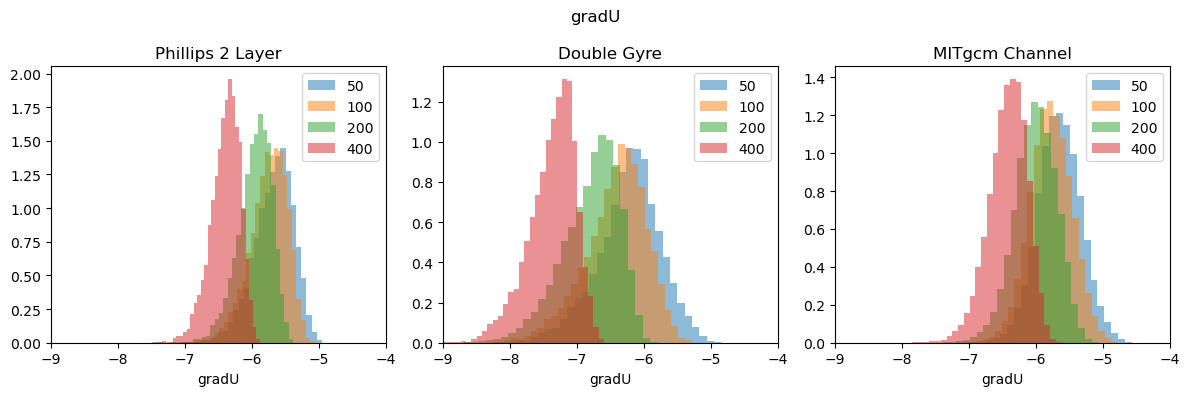

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_P2L_data.datatree[L]['gradU']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([-9, -4])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_DG_data.datatree[L]['gradU']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([-9, -4])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    np.log10(MITgcm_data.datatree[L]['gradU']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([-9, -4])


plt.suptitle('gradU')
plt.tight_layout()


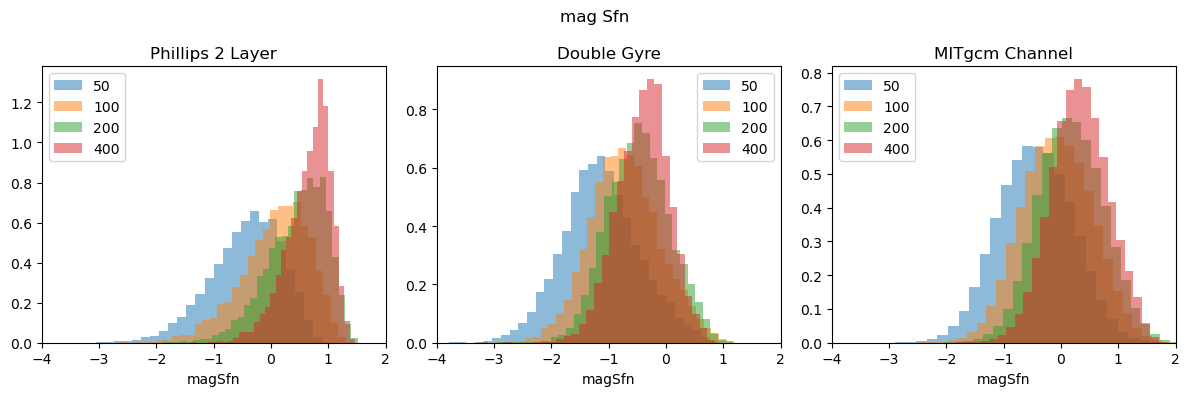

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_P2L_data.datatree[L]['magSfn']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([-4, 2])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    np.log10(MOM6_DG_data.datatree[L]['magSfn']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([-4, 2])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    np.log10(MITgcm_data.datatree[L]['magSfn']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([-4, 2])

plt.suptitle('mag Sfn')
plt.tight_layout()

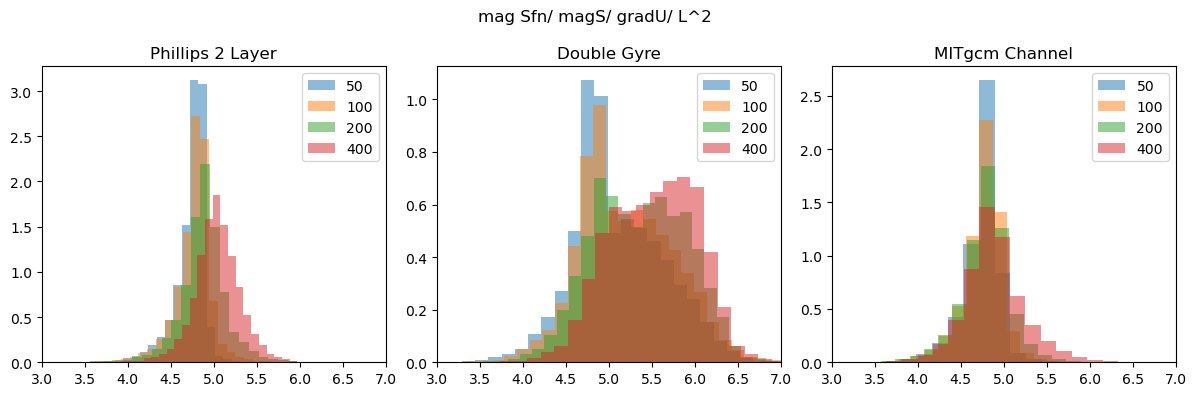

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_P2L_data.datatree[L]['magSfn']/MOM6_P2L_data.datatree[L]['magS']/MOM6_P2L_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
plt.xlim([3, 7])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_DG_data.datatree[L]['magSfn']/MOM6_DG_data.datatree[L]['magS']/MOM6_DG_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
plt.xlim([3, 7])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MITgcm_data.datatree[L]['magSfn']/MITgcm_data.datatree[L]['magS']/MITgcm_data.datatree[L]['gradU']/Lint**2).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
plt.xlim([3, 7])

plt.suptitle('mag Sfn/ magS/ gradU/ L^2')
plt.tight_layout()

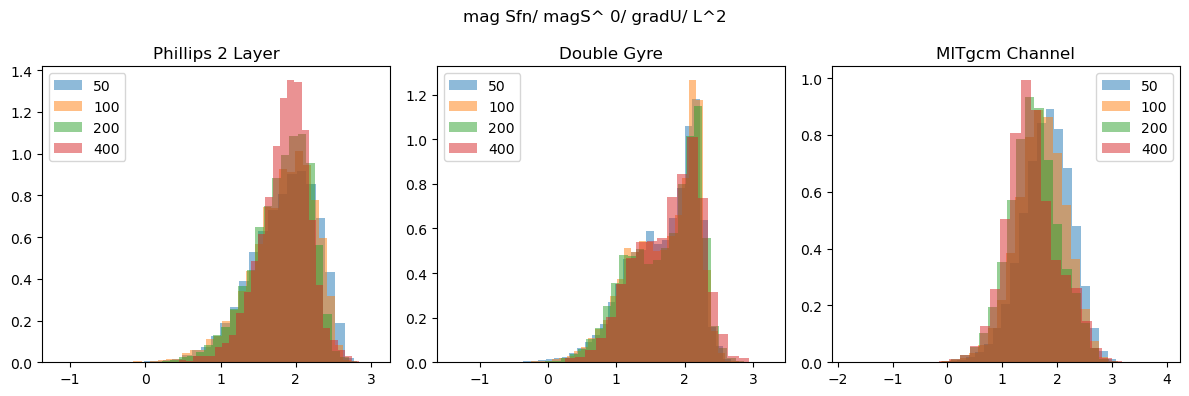

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_P2L_data.datatree[L]['magSfn']/MOM6_P2L_data.datatree[L]['magS']**0/MOM6_P2L_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
#plt.xlim([3, 7])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MOM6_DG_data.datatree[L]['magSfn']/MOM6_DG_data.datatree[L]['magS']**0/MOM6_DG_data.datatree[L]['gradU']/Lint**2).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
#plt.xlim([3, 7])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    Lint = int(L)
    np.log10(MITgcm_data.datatree[L]['magSfn']/MITgcm_data.datatree[L]['magS']**0/MITgcm_data.datatree[L]['gradU']/Lint**2).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
#plt.xlim([3, 7])

plt.suptitle('mag Sfn/ magS^ 0/ gradU/ L^2')
plt.tight_layout()

Text(0.5, 1.0, 'Phillips 2 Layer')

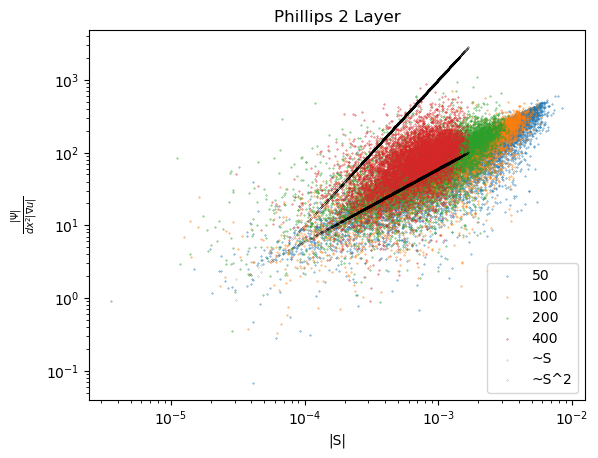

In [17]:
for L in ['50', '100', '200', '400']:
    Lint = int(L)

    y = MOM6_P2L_data.datatree[L]['magSfn']/MOM6_P2L_data.datatree[L]['gradU']/Lint**2
    x = MOM6_P2L_data.datatree[L]['magS']
    
    plt.scatter(x, y, s=0.1, label=L)
plt.scatter(x, 0.6e5*x, s=0.01, c='k', label='~S')
plt.scatter(x, 0.1e10*(x**2), s=0.01, c='k', label='~S^2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('|S|')
plt.ylabel(r'$\frac{|\Psi|}{dx^2 |\nabla u|}$')
plt.title('Phillips 2 Layer')

Part of the reason that the above scaling goes with S is likely because at some zeroth order Taylor series does a good job at representing these eddy fluxes. 

At some level the scaling of $|Psi| ~ dx^2 |\nabla u||S|$ explains the variance quite well. However, we know that this is not the full story because the non-linear models are able to learn more than these linear models (albeit at the cost of generalizability). 

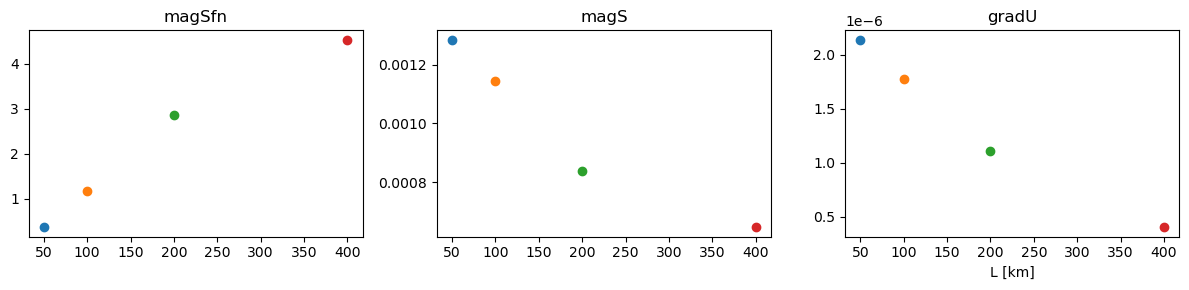

In [36]:
plt.figure(figsize=(12, 3))

for L in ['50', '100', '200', '400']:
    Lint = int(L)


    plt.subplot(131)
    y = np.log10(MOM6_P2L_data.datatree[L]['magSfn']).mean().values
    #print(y)
    plt.plot(Lint, 10**y, 'o', label='magSfn')
    
    plt.title('magSfn')


    plt.subplot(132)
    y = np.log10(MOM6_P2L_data.datatree[L]['magS']).mean()
    plt.plot(Lint, 10**y, 'o', label='magS')
    plt.title('magS')
    
    plt.subplot(133)
    y = np.log10(MOM6_P2L_data.datatree[L]['gradU']).mean()
    plt.plot(Lint, 10**y, 'o', label='gradU')
    plt.title('gradU')

#plt.scatter(x, 0.6e5*x, s=0.01, c='k', label='~S')
#plt.scatter(x, 0.1e10*(x**2), s=0.01, c='k', label='~S^2')
#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('L [km]')
#plt.ylabel(r'$\frac{|\Psi|}{dx^2 |\nabla u|}$')
#plt.title('Phillips 2 Layer')

plt.tight_layout()

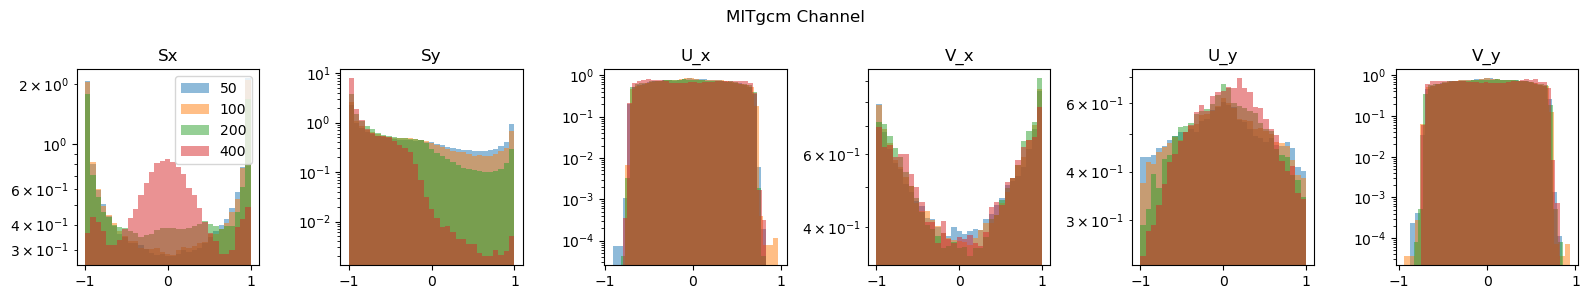

In [25]:
## inputs 

plt.figure(figsize=(16, 3))


for  L in ['50', '100', '200', '400']:
    ds = MITgcm_data.datatree[L]
    
    plt.subplot(1,6,1 )
    (ds.Sx/ds.magS).plot.hist(bins=31, alpha=0.5, label=L, density=True)
    plt.yscale('log')
    plt.title('Sx')
    plt.legend()
    
    plt.subplot(1,6,2 )
    (ds.Sy/ds.magS).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('Sy')
    
    plt.subplot(1,6,3  )
    (ds.U_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_x')
    
    plt.subplot(1,6,4  )
    (ds.V_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_x')
    
    plt.subplot(1,6,5  )
    (ds.U_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_y')
    
    plt.subplot(1,6,6  )
    (ds.V_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_y')
    
    
plt.suptitle('MITgcm Channel')
plt.tight_layout()


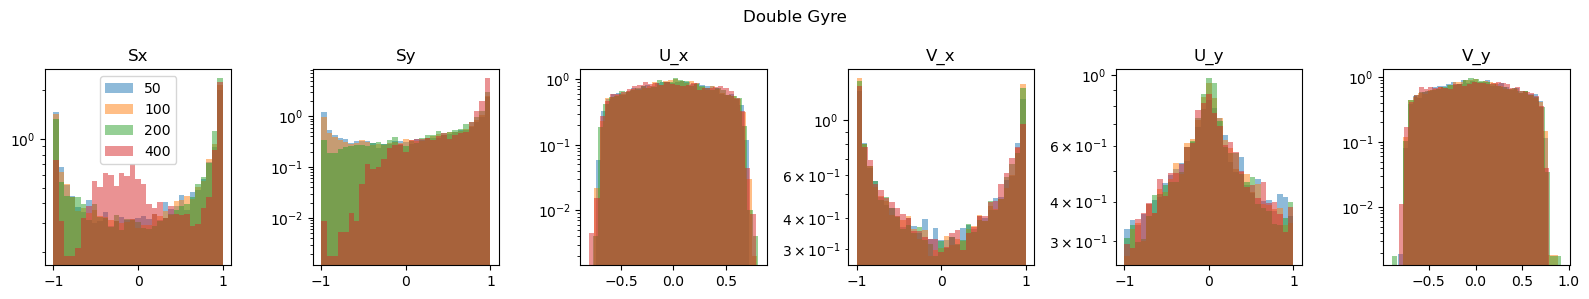

In [26]:
## inputs 

plt.figure(figsize=(16, 3))


for  L in ['50', '100', '200', '400']:
    ds = MOM6_DG_data.datatree[L]
    
    plt.subplot(1,6,1 )
    (ds.Sx/ds.magS).plot.hist(bins=31, alpha=0.5, label=L, density=True)
    plt.yscale('log')
    plt.title('Sx')
    plt.legend()
    
    plt.subplot(1,6,2 )
    (ds.Sy/ds.magS).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('Sy')
    
    plt.subplot(1,6,3  )
    (ds.U_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_x')
    
    plt.subplot(1,6,4  )
    (ds.V_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_x')
    
    plt.subplot(1,6,5  )
    (ds.U_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_y')
    
    plt.subplot(1,6,6  )
    (ds.V_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_y')
    
    
plt.suptitle('Double Gyre')
plt.tight_layout()


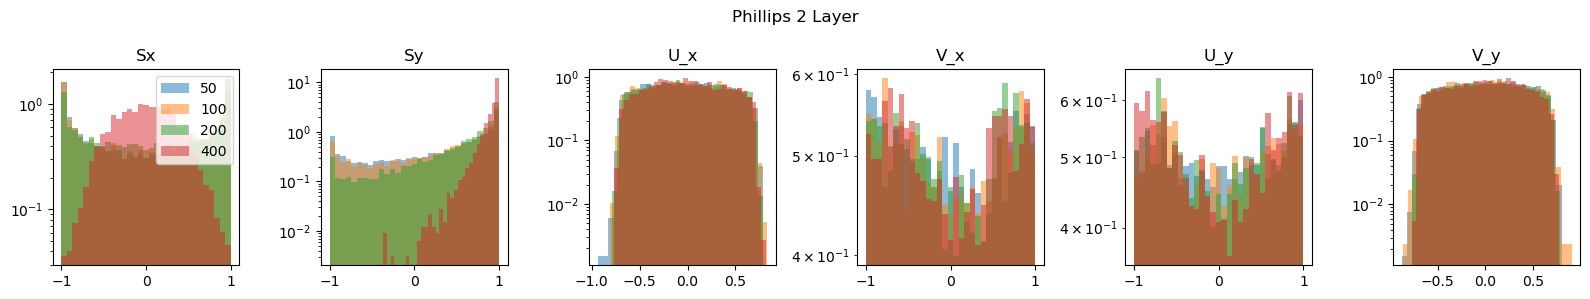

In [27]:
## inputs 

plt.figure(figsize=(16, 3))


for  L in ['50', '100', '200', '400']:
    ds = MOM6_P2L_data.datatree[L]
    
    plt.subplot(1,6,1 )
    (ds.Sx/ds.magS).plot.hist(bins=31, alpha=0.5, label=L, density=True)
    plt.yscale('log')
    plt.title('Sx')
    plt.legend()
    
    plt.subplot(1,6,2 )
    (ds.Sy/ds.magS).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('Sy')
    
    plt.subplot(1,6,3  )
    (ds.U_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_x')
    
    plt.subplot(1,6,4  )
    (ds.V_x/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_x')
    
    plt.subplot(1,6,5  )
    (ds.U_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('U_y')
    
    plt.subplot(1,6,6  )
    (ds.V_y/ds.gradU).plot.hist(bins=31, alpha=0.5, density=True)
    plt.yscale('log')
    plt.title('V_y')
    
    
plt.suptitle('Phillips 2 Layer')
plt.tight_layout()


### Are fluxes dissipative

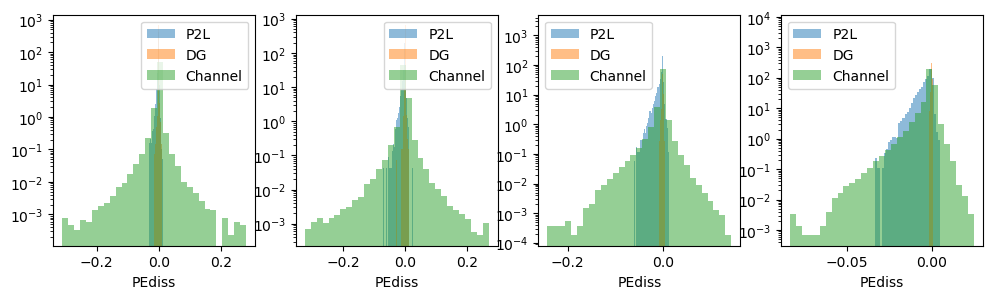

In [45]:
plt.figure(figsize=(12, 3))

for i, L in enumerate(['50', '100', '200', '400']):
    plt.subplot(1,4,1+i)
    (MOM6_P2L_data.datatree[L]['PEdiss']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='P2L', density=True)
    (MOM6_DG_data.datatree[L]['PEdiss']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='DG', density=True)
    (MITgcm_data.datatree[L]['PEdiss']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='Channel', density=True)
    plt.legend()
    plt.yscale('log')

plt.tight_layout()


Text(0.5, 0.98, 'Effective Kappa')

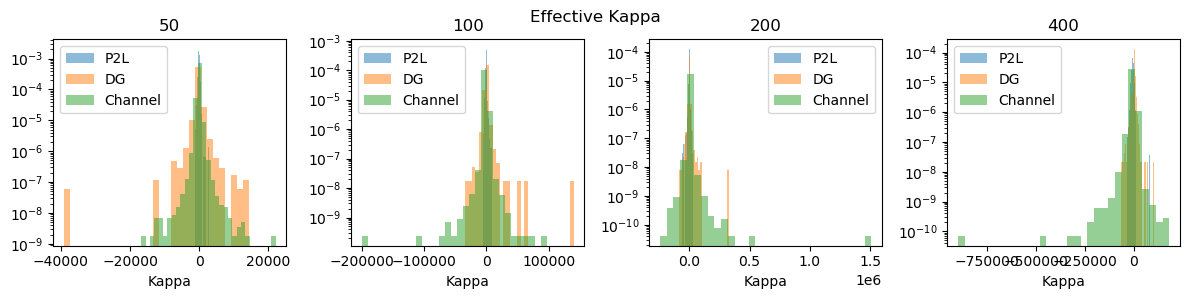

In [47]:
plt.figure(figsize=(12, 3))

for i, L in enumerate(['50', '100', '200', '400']):
    plt.subplot(1,4,1+i)
    (MOM6_P2L_data.datatree[L]['Kappa']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='P2L', density=True)
    (MOM6_DG_data.datatree[L]['Kappa']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='DG', density=True)
    (MITgcm_data.datatree[L]['Kappa']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label='Channel', density=True)
    plt.legend()
    plt.yscale('log')
    plt.title(L)

plt.tight_layout()
plt.suptitle('Effective Kappa')

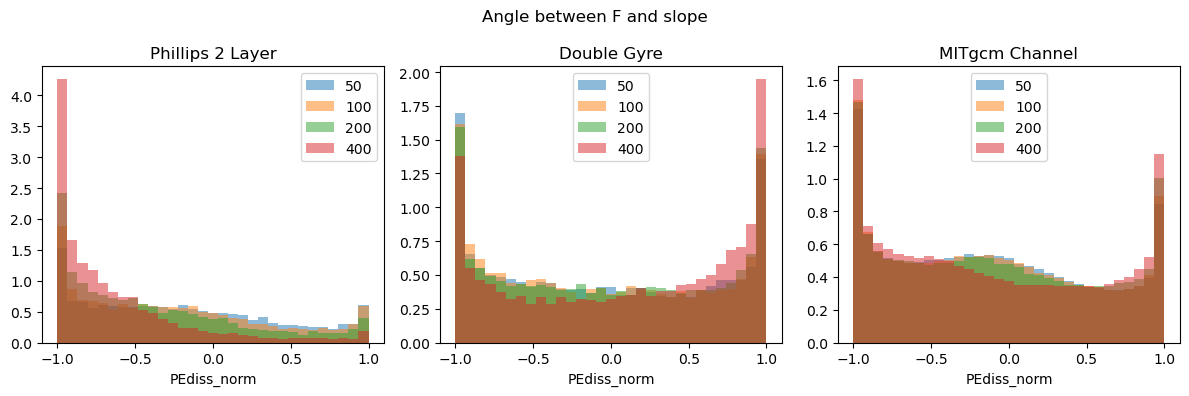

In [48]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
for L in ['50', '100', '200', '400']:
    (MOM6_P2L_data.datatree[L]['PEdiss_norm']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Phillips 2 Layer')
#plt.xlim([-5, -2])

plt.subplot(132)
for L in ['50', '100', '200', '400']:
    (MOM6_DG_data.datatree[L]['PEdiss_norm']).isel(Time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('Double Gyre')
#plt.xlim([-5, -2])

plt.subplot(133)
for L in ['50', '100', '200', '400']:
    (MITgcm_data.datatree[L]['PEdiss_norm']).isel(time=slice(-50, -1)).plot.hist(bins=31, alpha=0.5, label=L, density=True)
plt.legend()
plt.title('MITgcm Channel')
#plt.xlim([-5, -2])

plt.suptitle('Angle between F and slope')
plt.tight_layout()



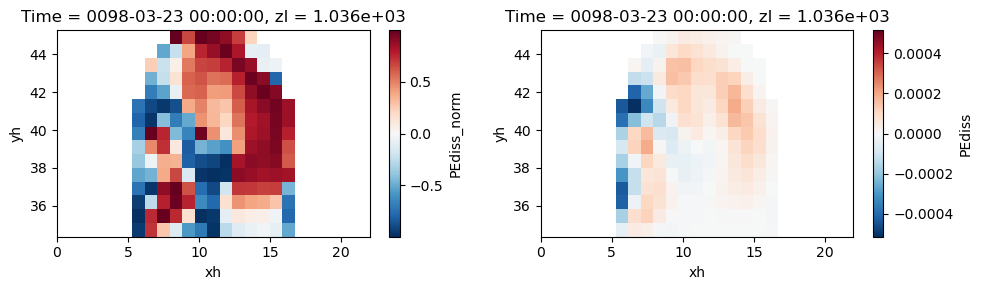

In [55]:
plt.figure(figsize=(10, 3))
L='400'
plt.subplot(121)
MOM6_DG_data.datatree[L]['PEdiss_norm'].isel(Time=0).plot()

plt.subplot(122)
MOM6_DG_data.datatree[L]['PEdiss'].isel(Time=0).plot()

plt.tight_layout()

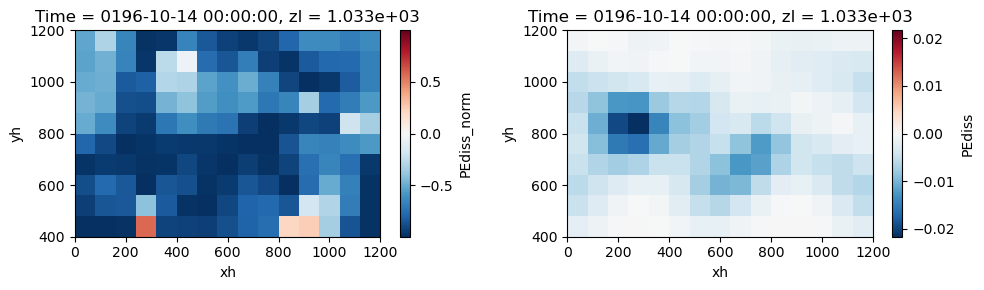

In [56]:
plt.figure(figsize=(10, 3))
L='400'
plt.subplot(121)
MOM6_P2L_data.datatree[L]['PEdiss_norm'].isel(Time=0).plot()

plt.subplot(122)
MOM6_P2L_data.datatree[L]['PEdiss'].isel(Time=0).plot()

plt.tight_layout()

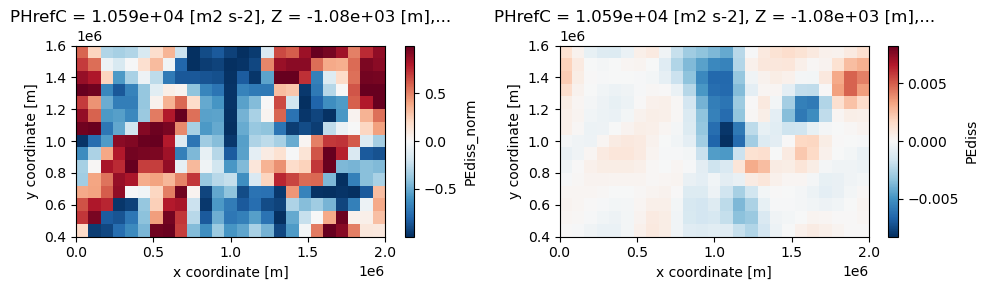

In [57]:
plt.figure(figsize=(10, 3))
L='400'
plt.subplot(121)
MITgcm_data.datatree[L]['PEdiss_norm'].isel(time=0, Z=10).plot()

plt.subplot(122)
MITgcm_data.datatree[L]['PEdiss'].isel(time=0, Z=10).plot()

plt.tight_layout()

Interesting to note that while the distributions of PE dissipation by eddies skews negative, the normalized version of this does not necessarily. Basically it is not the case that there are necessarily more events of downgradient thickness flux, but rather that the events of downgradient thickness flux that are taking place are often quite strong.

### Some maps

In [11]:
MOM6_DG_data.dataset

<xarray.Dataset>
Dimensions:    (Time: 3600, zl: 2, yh: 27, xh: 25, zi: 3)
Coordinates:
  * Time       (Time) object 0001-01-11 00:00:00 ... 0099-07-26 00:00:00
  * xh         (xh) float64 0.44 1.32 2.2 3.08 3.96 ... 18.92 19.8 20.68 21.56
  * yh         (yh) float64 30.36 31.09 31.82 32.55 ... 47.09 47.82 48.55 49.27
  * zi         (zi) float64 1.034e+03 1.036e+03 1.037e+03
  * zl         (zl) float64 1.035e+03 1.036e+03
Data variables: (12/26)
    dudx       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    dudy       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    dvdx       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    dvdy       (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    e          (Time, zi, yh, xh) float32 dask.array<chunksize=(36, 3, 27, 25), meta=np.ndarray>
    h          (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    ...         ...
    vh         (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vh_bar     (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vh_sg      (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vv         (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vv_bar     (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>
    vv_sg      (Time, zl, yh, xh) float32 dask.array<chunksize=(36, 2, 27, 25), meta=np.ndarray>

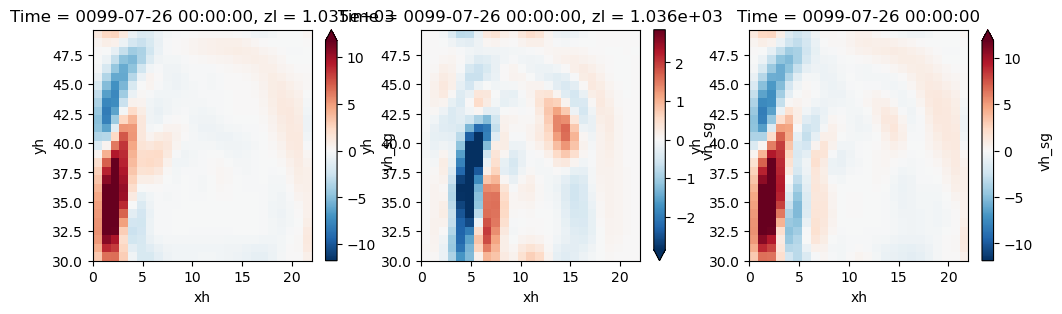

In [17]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=0).plot( robust=True)

plt.subplot(132)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=1).plot( robust=True)

plt.subplot(133)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1).sum('zl').plot( robust=True)

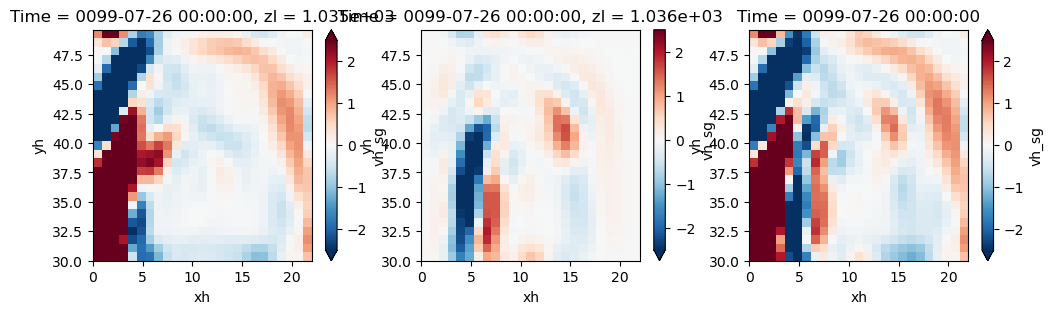

In [18]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=0).plot( vmin=-2.5)

plt.subplot(132)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1, zl=1).plot( vmin=-2.5)

plt.subplot(133)
MOM6_DG_data.dataset.vh_sg.isel(Time=-1).sum('zl').plot( vmin=-2.5)

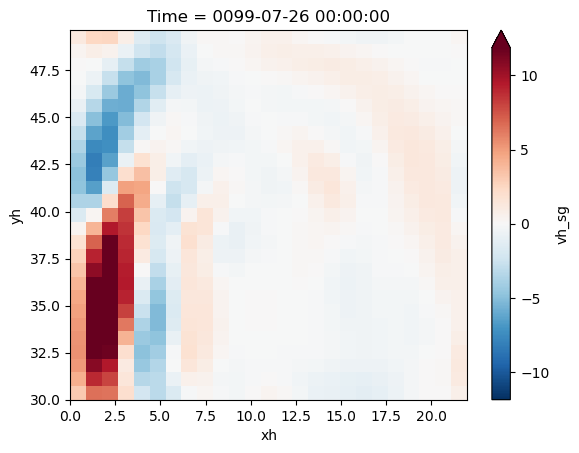

In [16]:
MOM6_DG_data.dataset.vh_sg.isel(Time=-1).plot( robust=True)

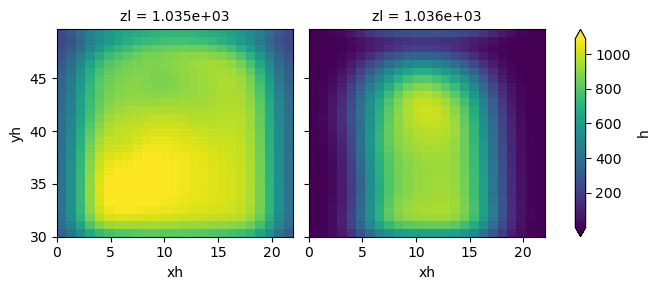

In [15]:
MOM6_DG_data.dataset.h.isel(Time=-1).plot(col='zl', robust=True)